In [2]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
   
import torch
from torch.utils.data.dataloader import DataLoader 
from torchvision import transforms
    
from Net.hpatches_dataset import (HPatchesDataset, Grayscale, 
                                  Normalize, Rescale, ToTensor)
from Net.exp_env.analyze_config import cfg
from Net.utils.image_utils import *
from Net.utils.eval_utils import torch2cv, to_cv2_keypoint

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.jet())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

In [7]:
torch.manual_seed(9)
dataset = HPatchesDataset(root_path=cfg.DATASET.view.root,
                              csv_file=cfg.DATASET.view.analyze_csv,
                              transform=transforms.Compose([
                                  Grayscale(),
                                  Rescale((960, 1280)),
                                  Rescale((320, 640)),
                                  ToTensor(),
                              ]), include_sources=True)

loader = DataLoader(dataset, 1, False)

In [8]:
batch = next(loader.__iter__())
image1 = batch['image1']
image2 = batch['image2']
homo12 = batch['homo12']
homo21 = batch['homo21']

In [9]:
w_image1 = warp_image(image2, image1, homo21)
w_image2 = warp_image(image1, image2, homo12)

print(image1.gt(0.3).nonzero())

w_kp1 = warp_keypoints(image1.gt(0.3).nonzero(), homo12)
wkp1_map = torch.zeros(image2.size())
wkp1_map[w_kp1[:, 0], w_kp1[:, 1], w_kp1[:, 2], w_kp1[:, 3]] = 1

w_kp2 = warp_keypoints(image2.gt(0.1).nonzero(), homo21)
h_mask = w_kp2[:, 2].lt(image1.size(2))
w_kp2 = w_kp2[h_mask, :]
w_mask = w_kp2[:, 3].lt(image1.size(3))
w_kp2 = w_kp2[w_mask, :]

wkp2_map = torch.zeros(image1.size())
wkp2_map[w_kp2[:, 0], w_kp2[:, 1], w_kp2[:, 2], w_kp2[:, 3]] = 1

tensor([[  0,   0,  29, 233],
        [  0,   0,  30, 234],
        [  0,   0,  31, 234],
        ...,
        [  0,   0, 319, 632],
        [  0,   0, 319, 633],
        [  0,   0, 319, 639]])


In [10]:
im1show = torch2cv(image1).repeat(3, axis=2)
im2show = torch2cv(image2).repeat(3, axis=2)

w_im1show = torch2cv(w_image1).repeat(3, axis=2)
w_im2show = torch2cv(w_image2).repeat(3, axis=2)

kp1_show = torch2cv(wkp1_map).repeat(3, axis=2)
kp2_show = torch2cv(wkp2_map).repeat(3, axis=2)


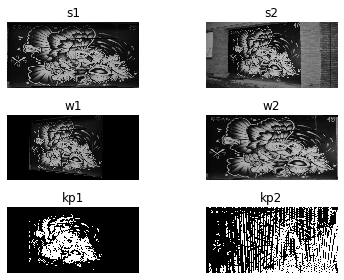

In [11]:
plot_figures({'s1': im1show, 
              's2': im2show,
              'w1': w_im1show,
              'w2': w_im2show,
              'kp1': kp1_show,
              'kp2': kp2_show,
              }, 3, 2)

plt.imsave('s1.png', im1show)
plt.imsave('s2.png', im2show)
plt.imsave('kp1.png', kp1_show)
plt.imsave('kp2.png', kp2_show)